In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
sys.path.append('/content/drive/MyDrive/NNDL2/Project')

## Load data
- event/eicu-dataset.pkl: dict object mapping unit_id to label and chronological data
- event/icd9code.pkl: dict object mapping unit_id to icd9code(diagnosis code)
- event/vocab.json: dict object mapping event to event_id

In [2]:
import pickle
import numpy as np
from collections import Counter
import tensorflow as tf
import random
import pandas as pd
import json
from model.seq import LSTM, Transformer, MOE

# eicu data dict mapping unitid to label and chronological data
# x: (len, 3) (event_id, event_value, event_offset)
with open('/content/drive/MyDrive/NNDL2/Project/event/eicu-dataset.pkl', 'rb') as f: data = pickle.load(f)
patients = pd.read_csv('/content/drive/MyDrive/NNDL2/Project/event/patients.csv')
unit_icd = pd.Series.to_dict(patients.set_index('patientunitstayid')['icd9code'])
with open('/content/drive/MyDrive/NNDL2/Project/event/vocab.json','r') as f: vocab = json.load(f)

remove icdcode with less than 2 expired samples (may be used to evaluate task-similarity model performance)  
compute expired samples ratio w.r.t icdcode

In [3]:
icd = [unit_icd[k] for k in data]
icd_cnt = Counter(icd)
icd_death_rt = {}
for icd in icd_cnt: icd_death_rt[icd] = 0
for k,v in data.items(): icd_death_rt[unit_icd[k]] += int(v[0] == 'Expired')
icd_study = [icd for icd, rt in icd_death_rt.items() if rt >=2]
for icd in icd_death_rt: icd_death_rt[icd] /= icd_cnt[icd]
len(icd_study)

251

In [ ]:
min([icd_cnt[icd] for icd in icd_study]), max([icd_cnt[icd] for icd in icd_study]), np.median([d[1].shape[0] for k, d in data.items()])

(7, 202, 2215.0)

In [4]:
seed = 1024 # Change different seeds for experiments
random.seed(seed)
max_len = 200

Split dataset in each icd9code for alive and expired samples respectively 

In [5]:
def split_indices(size, test_split = 0.2):
  cands = list(range(size))
  random.shuffle(cands)
  tr_num = int(len(cands)*(1-test_split))
  return cands[:tr_num], cands[tr_num:]

def split_by_icd(x, y, icds):
  train = {}
  test = {}
  for idx, icd in enumerate(icd_study):
    indices = [i for i, icd9 in enumerate(icds) if icd9 == icd]
    sx, sy = x[indices], y[indices]
    sxd = sx[sy == 1]
    trd, ted = split_indices(sxd.shape[0])
    sxa = sx[sy == 0]
    tra, tea = split_indices(sxa.shape[0])
    train[icd] = (np.concatenate([sxa[tra], sxd[trd]], axis = 0), np.array([0]*len(tra)+[1]*len(trd)), np.array([idx]*(len(tra)+len(trd))))
    test[icd] = (np.concatenate([sxa[tea], sxd[ted]], axis = 0), np.array([0]*len(tea)+[1]*len(ted)), np.array([idx]*(len(tea)+len(ted))))
  return train, test

def padding(r, len):
  if r.shape[0] < len: return np.pad(r, ((0, len - r.shape[0]), (0,0)), constant_values = (0,))
  if r.shape[0] >= len: return r[-len:]

In [6]:
#construct dataset in numpy array obeject
x = []
y = []
icds = []
for k in data:
  icds.append(unit_icd[k])
  x.append(padding(data[k][1], max_len)[None,:,:])
  y.append(int(data[k][0] == 'Expired'))
x = np.concatenate(x, axis = 0)
y = np.array(y)
x = np.nan_to_num(x)

In [7]:
# dict mapping icd to corresponding dataset
train_dict, test_dict = split_by_icd(x, y, icds)

## baseline model, treat all icds as one single task

In [8]:
tr_x = np.concatenate([x[0] for k, x in train_dict.items()], axis = 0)
tr_y = np.concatenate([x[1] for k, x in train_dict.items()], axis = 0)
tr_k = np.concatenate([x[2] for k ,x in train_dict.items()], axis = 0)
te_x = np.concatenate([x[0] for k, x in test_dict.items()], axis = 0)
te_y = np.concatenate([x[1] for k, x in test_dict.items()], axis = 0)
te_k = np.concatenate([x[2] for k, x in test_dict.items()], axis = 0)
print(f'{tr_x.shape}, {te_x.shape}')

(13370, 200, 3), (3601, 200, 3)


In [9]:
indices = list(range(tr_x.shape[0]))
random.shuffle(indices)
tr_x, tr_y, tr_k = tr_x[indices], tr_y[indices], tr_k[indices]

In [10]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, decay_steps = 35, decay_rate = 0.8) # For others

In [ ]:
seqm = MOE(10)
inputs, outputs = seqm.build(max_len, max(vocab.values())+1)
moe_model = tf.keras.Model(inputs = inputs, outputs = outputs)
moe_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_decay),  
                  loss = tf.keras.losses.BinaryCrossentropy(), 
                  metrics = [tf.keras.metrics.AUC(name='ROC'),tf.keras.metrics.AUC(curve='PR', name = 'PRC')])

In [11]:
seqm = LSTM()
inputs, outputs = seqm.build(max_len, max(vocab.values())+1)
lstm_model = tf.keras.Model(inputs = inputs, outputs = outputs)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_decay),  
                   loss = tf.keras.losses.BinaryCrossentropy(), 
                   metrics = [tf.keras.metrics.AUC(name='ROC'),tf.keras.metrics.AUC(curve='PR', name = 'PRC')])

In [14]:
seqm = Transformer()
inputs, outputs = seqm.build(max_len, max(vocab.values())+1)
tf_model = tf.keras.Model(inputs = inputs, outputs = outputs)
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_decay),  
                 loss = tf.keras.losses.BinaryCrossentropy(), 
                 metrics = [tf.keras.metrics.AUC(name='ROC'),tf.keras.metrics.AUC(curve='PR', name = 'PRC')])

In [ ]:
estop = tf.keras.callbacks.EarlyStopping(monitor='val_PRC', patience=8, mode = 'max', restore_best_weights=True)
history_moe = moe_model.fit(x = (tr_x[:,:,0], tr_x[:,:,1]), y = tr_y, 
                                 batch_size = 256, epochs = 15, validation_split = 0.33,
                                 callbacks=[estop])

In [12]:
estop = tf.keras.callbacks.EarlyStopping(monitor='val_PRC', patience=8, mode = 'max', restore_best_weights=True)
history_lstm = lstm_model.fit(x = (tr_x[:,:,0], tr_x[:,:,1]), y = tr_y, 
                                   batch_size = 256, epochs = 15, validation_split = 0.33,
                                   callbacks=[estop])

Epoch 1/15
35/35 [==============================] - 36s 919ms/step - loss: 0.3852 - ROC: 0.4927 - PRC: 0.0822 - val_loss: 0.2882 - val_ROC: 0.4841 - val_PRC: 0.0760
Epoch 2/15
35/35 [==============================] - 31s 895ms/step - loss: 0.2663 - ROC: 0.5346 - PRC: 0.0823 - val_loss: 0.2857 - val_ROC: 0.5140 - val_PRC: 0.0944
Epoch 3/15
35/35 [==============================] - 31s 890ms/step - loss: 0.2704 - ROC: 0.5559 - PRC: 0.0968 - val_loss: 0.2835 - val_ROC: 0.5549 - val_PRC: 0.1000
Epoch 4/15
35/35 [==============================] - 32s 922ms/step - loss: 0.2697 - ROC: 0.5768 - PRC: 0.0988 - val_loss: 0.2817 - val_ROC: 0.5780 - val_PRC: 0.1068
Epoch 5/15
35/35 [==============================] - 32s 911ms/step - loss: 0.2691 - ROC: 0.6079 - PRC: 0.1101 - val_loss: 0.2791 - val_ROC: 0.6060 - val_PRC: 0.1124
Epoch 6/15
35/35 [==============================] - 31s 900ms/step - loss: 0.2639 - ROC: 0.6122 - PRC: 0.1051 - val_loss: 0.2767 - val_ROC: 0.6238 - val_PRC: 0.1162
Epoch 7/15

In [15]:
estop = tf.keras.callbacks.EarlyStopping(monitor='val_PRC', patience=8, mode = 'max', restore_best_weights=True)
history_tf = tf_model.fit(x = (tr_x[:,:,0], tr_x[:,:,1]), y = tr_y, 
                               batch_size = 256, epochs = 15, validation_split = 0.33,
                               callbacks=[estop])

Epoch 1/15
35/35 [==============================] - 21s 462ms/step - loss: 0.3501 - ROC: 0.5362 - PRC: 0.0827 - val_loss: 0.2745 - val_ROC: 0.6521 - val_PRC: 0.1693
Epoch 2/15
35/35 [==============================] - 15s 427ms/step - loss: 0.2562 - ROC: 0.6373 - PRC: 0.1187 - val_loss: 0.2622 - val_ROC: 0.6931 - val_PRC: 0.2065
Epoch 3/15
35/35 [==============================] - 15s 429ms/step - loss: 0.2502 - ROC: 0.7010 - PRC: 0.1941 - val_loss: 0.2587 - val_ROC: 0.7038 - val_PRC: 0.2206
Epoch 4/15
35/35 [==============================] - 15s 425ms/step - loss: 0.2458 - ROC: 0.6926 - PRC: 0.1862 - val_loss: 0.2613 - val_ROC: 0.7083 - val_PRC: 0.2183
Epoch 5/15
35/35 [==============================] - 15s 425ms/step - loss: 0.2418 - ROC: 0.7190 - PRC: 0.2297 - val_loss: 0.2568 - val_ROC: 0.7324 - val_PRC: 0.2356
Epoch 6/15
35/35 [==============================] - 15s 426ms/step - loss: 0.2368 - ROC: 0.7385 - PRC: 0.2346 - val_loss: 0.2557 - val_ROC: 0.7465 - val_PRC: 0.2472
Epoch 7/15

In [13]:
lstm_model.evaluate(x = (te_x[:,:,0], te_x[:,:,1]), y = te_y)

113/113 [==============================] - 8s 71ms/step - loss: 0.3436 - ROC: 0.6356 - PRC: 0.1802


[0.3436291813850403, 0.6356477737426758, 0.18019533157348633]

In [ ]:
tf_model.evaluate(x = (te_x[:,:,0], te_x[:,:,1]), y = te_y)

In [14]:
# indicate the model of which history is needed to be plot
history = history_lstm

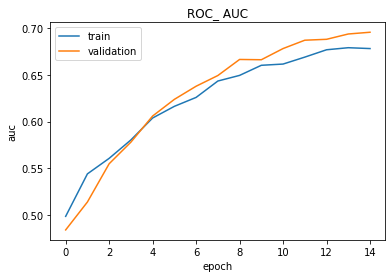

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['ROC'])
plt.plot(history.history['val_ROC'])
plt.title('ROC_ AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

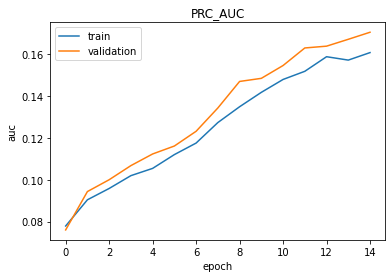

In [16]:
plt.plot(history.history['PRC'])
plt.plot(history.history['val_PRC'])
plt.title('PRC_AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

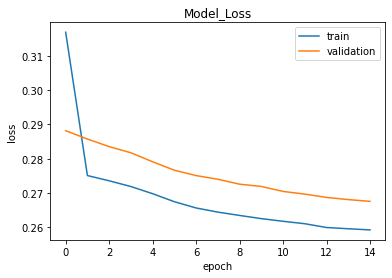

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()